In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os


# pytorch: helps us make model
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset
import torch.nn.functional as F
import torch.nn as nn

# sklearn: help to genrate predicitve report
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split

# huggingface: Stores pre-trained models
from transformers import BertTokenizer #, BertForSequenceClassification, set_seed
from transformers import BertModel, AdamW, BertConfig
from transformers import pipeline, AdamW, get_linear_schedule_with_warmup
import json 



In [3]:
tweet= pd.read_csv('../input/nlp-getting-started/train.csv')
test=pd.read_csv('../input/nlp-getting-started/test.csv')
tweet.head(3)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


In [4]:
tweet.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

<AxesSubplot:xlabel='target', ylabel='count'>

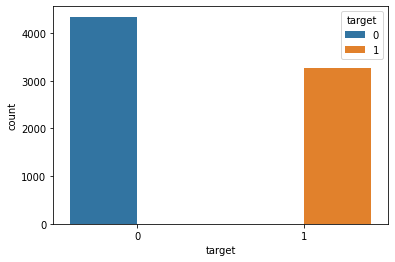

In [5]:
# plt.style.use('ggplot')
sns.countplot(x="target", data=tweet ,hue="target")


Text(0.5, 1.0, 'Not disaster tweets')

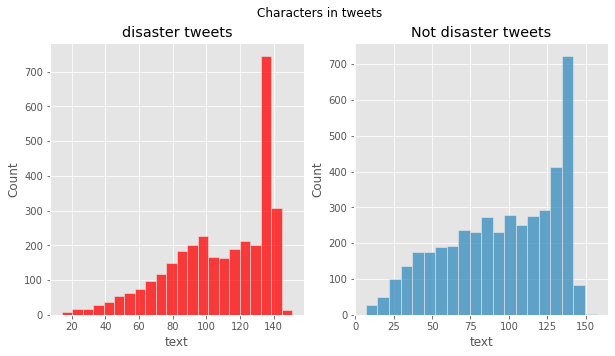

In [6]:
plt.style.use('ggplot')
f,axes=plt.subplots(1,2,figsize=(10,5))
f.suptitle('Characters in tweets')

tweet_len=tweet[tweet['target']==1]['text'].str.len()
ax1=sns.histplot(tweet_len,ax=axes[0],color='red')
# ax1.set(xlabel='common xlabel', ylabel='common ylabel')
ax1.set_title('disaster tweets')

tweet_len=tweet[tweet['target']==0]['text'].str.len()
ax2=sns.histplot(tweet_len,ax=axes[1])
# ax2.set(xlabel='common xlabel', ylabel='common ylabel')
ax2.set_title('Not disaster tweets')


<AxesSubplot:ylabel='Count'>

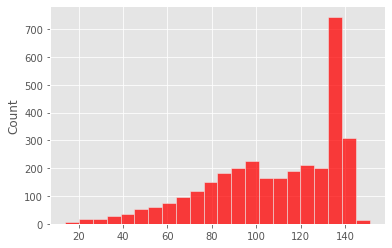

In [7]:
tweet_len=tweet[tweet['target']==1]['text'].str.len()
sns.histplot(tweet_len.values,color='red')

Text(0.5, 1.0, 'Not disaster tweets')

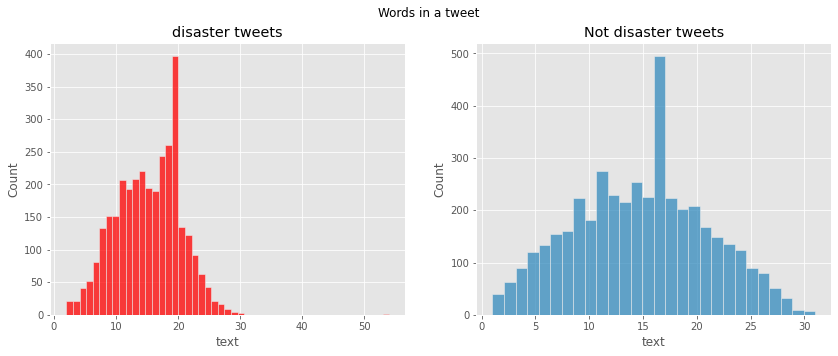

In [8]:
plt.style.use('ggplot')
f,axes=plt.subplots(1,2,figsize=(14,5))
f.suptitle('Words in a tweet')
tweet_len=tweet[tweet.target==1]['text'].str.split(' ').map(lambda x: len(x))
ax1=sns.histplot(tweet_len,ax=axes[0],color='red')
# ax1.set(xlabel='common xlabel', ylabel='common ylabel')
ax1.set_title('disaster tweets')

tweet_len=tweet[tweet.target==0]['text'].str.split(' ').map(lambda x: len(x))
ax2=sns.histplot(tweet_len,ax=axes[1])
# ax2.set(xlabel='common xlabel', ylabel='common ylabel')
ax2.set_title('Not disaster tweets')


In [9]:
text=''
for i in tweet['text']:
    text+=i
#     print(i)
#     break

In [10]:
from collections import defaultdict,Counter
count_punctuation=defaultdict(int)
import string

for x,y in Counter(text).items():

    if x in string.punctuation:
#         print(x)
#         print(type(x))
        count_punctuation[x]=y
#         print(x,y)
#     print(x,y)
#     break
print(count_punctuation)


defaultdict(<class 'int'>, {'#': 3403, '.': 11696, "'": 3157, ',': 2, '=': 53, '>': 1, '-': 1753, '?': 3126, '!': 1173, ';': 587, ')': 373, ':': 6910, '@': 2759, '/': 14585, '_': 863, '&': 457, '(': 349, '[': 132, ']': 131, '|': 152, '*': 179, '$': 44, '+': 80, '%': 46, '~': 37, '}': 4, '^': 6, '\\': 5, '`': 3, '{': 3})


Text(0.5, 1.0, 'Count of Punctuations')

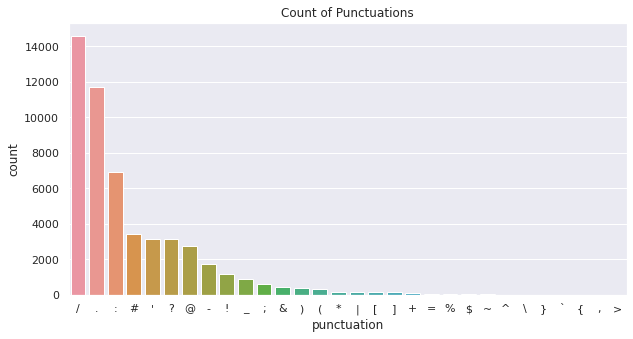

In [11]:
sns.set(rc={'figure.figsize':(10,5)})
ax=sns.barplot(x='punctuation',y='count',
            data=pd.DataFrame(count_punctuation.items()
                              ,columns=['punctuation','count']).sort_values
            (by=['count'], ascending=False))
ax.set_title('Count of Punctuations')


In [12]:
# Common words
word_count=Counter(text.split(' '))
most_common=word_count.most_common(40)


<AxesSubplot:xlabel='count', ylabel='word'>

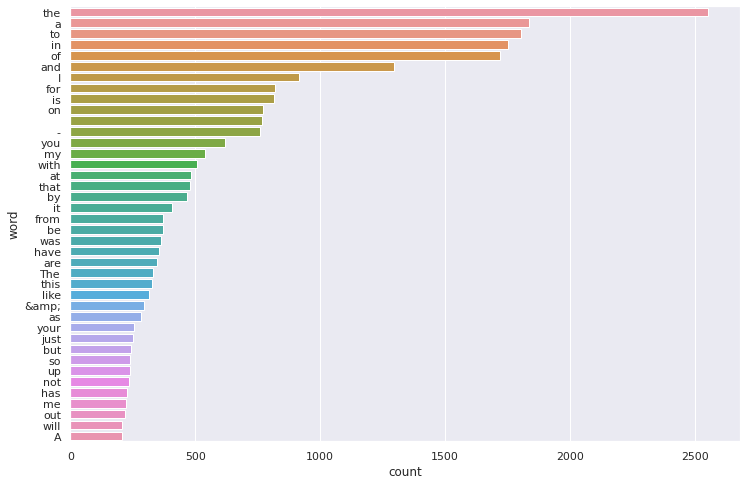

In [13]:
sns.set(rc={'figure.figsize':(12,8)})
sns.barplot(x='count',y='word',data=pd.DataFrame(most_common,columns=['word','count']))

In [14]:
import re
import string
import spacy
sp = spacy.load('en_core_web_sm')

def cleaning_text(text,emojis=True,html_tag=True,http=True,lemmitize=True,punctuation=True):
    
    #remove emojis
    if emojis is True:
        regrex_pattern = re.compile(pattern = "["                                                   
                                    u"\U0001F600-\U0001F64F"  # emoticons
                                    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                    u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                    u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                                       "]+", flags = re.UNICODE)

        text=regrex_pattern.sub(r'',text)
    
    
    
    #lower 
    text=text.lower()
    
    #remove html tag
    if html_tag is True:
        text=re.sub('<.*?>',"",text)
        
    #remove http link
    if http is True:
        text = re.sub("https?:\/\/t.co\/[A-Za-z0-9]*", '', text)
    
#     lemmitizing
    if lemmitize is True:
        lemmatized = [word.lemma_ for word in sp(text)]
        text = ' '.join(lemmatized)
    
    #remove punctuation
    if punctuation is True:
        text = text.translate(str.maketrans('', '', string.punctuation))
        
    # removing extra space
    text = re.sub("\s+", ' ', text)
    
    
#     print(text)
    
    return text

In [15]:
tweet['cleaned']=tweet['text'].apply(lambda x: cleaning_text(x,lemmitize=False))

In [16]:
tweet.head()

,id,keyword,location,text,target,cleaned
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...


In [17]:
from sklearn.model_selection import train_test_split
# split dataset into train and val for validating model performance
x_train, x_val, y_train, y_val = train_test_split(
    tweet['cleaned'].values, tweet['target'].values, test_size=0.05, stratify=tweet['target'].values)


In [18]:
x_train.shape,x_val.shape

((7232,), (381,))

In [19]:
# init tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# get embedings

encoded_data_train = tokenizer.batch_encode_plus(
    list(x_train), 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    padding='max_length',
    max_length=50,   # max length is taken 50 as max len of tweets is around 30
    return_tensors='pt',
    truncation=True,
    return_token_type_ids=False
)

encoded_data_val = tokenizer.batch_encode_plus(
    list(x_val), 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True,
    padding='max_length', 
    max_length=50, 
    return_tensors='pt',
    truncation=True,
    return_token_type_ids=False
)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [20]:
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(list(y_train))#.float()

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(list(y_val))#.float()


# making dataset
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

# making dataloader
dataloader_train = DataLoader(dataset_train, sampler=RandomSampler(dataset_train), batch_size=8)
dataloader_val = DataLoader(dataset_val, sampler=SequentialSampler(dataset_val), batch_size=8)

In [21]:
#building model
class SentimentClassifier(nn.Module):
    
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.drop = nn.Dropout(p=0.1)
        self.out1 = nn.Linear(self.bert.config.hidden_size, 300)
        self.out2 = nn.Linear(300, 50)
        self.out3 = nn.Linear(50, n_classes)
        
    def forward(self, input_ids, attention_mask):
        o = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )

        output = torch.max(o.last_hidden_state, axis=1).values  #global_max_1d of tensorflow
        output = self.out1(output)
        output = torch.relu(output)
        
        output = self.drop(output)
        
        output = self.out2(output)
        output = torch.relu(output)
        
        output = self.out3(output)
        
        return output


In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = SentimentClassifier(n_classes=2)
model = model.to(device)

cuda


Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [23]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )
from transformers import get_linear_schedule_with_warmup
# Number of training epochs (authors recommend between 2 and 4)
epochs = 3
# Total number of training steps is number of batches * number of epochs.
total_steps = len(dataloader_train) * epochs
# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
loss_fn = nn.CrossEntropyLoss().to(device)

In [24]:
import numpy as np
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [25]:
import time
import datetime
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [26]:
import random
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128
# Set the seed value all over the place to make this reproducible.
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
# Store the average loss after each epoch so we can plot them.
loss_values = []
# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    # Measure how long the training epoch takes.
    t0 = time.time()
    # Reset the total loss for this epoch.
    total_loss = 0
    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()
    # For each batch of training data...
    for step, batch in enumerate(dataloader_train):
        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(dataloader_train), elapsed))
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        
        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids,  
                    attention_mask=b_input_mask)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        # output=torch.argmax(outputs,axis=1)
        # print(outputs)
        # print(b_labels)
        loss=loss_fn(outputs, b_labels)

        # print("loss ",loss)
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()
        # Update the learning rate.
        scheduler.step()
    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(dataloader_train)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.
    print("")
    print("Running Validation...")
    t0 = time.time()
    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()
    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    # Evaluate data for one epoch
    for batch in dataloader_val:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids,  
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        # logits = outputs[0]
        logits=torch.sigmoid(outputs)

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy
        # Track the number of batches
        nb_eval_steps += 1
    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))
print("")
print("Training complete!")


======== Epoch 1 / 3 ========
Training...
  Batch    40  of    904.    Elapsed: 0:00:06.
  Batch    80  of    904.    Elapsed: 0:00:11.
  Batch   120  of    904.    Elapsed: 0:00:16.
  Batch   160  of    904.    Elapsed: 0:00:21.
  Batch   200  of    904.    Elapsed: 0:00:26.
  Batch   240  of    904.    Elapsed: 0:00:31.
  Batch   280  of    904.    Elapsed: 0:00:35.
  Batch   320  of    904.    Elapsed: 0:00:40.
  Batch   360  of    904.    Elapsed: 0:00:45.
  Batch   400  of    904.    Elapsed: 0:00:50.
  Batch   440  of    904.    Elapsed: 0:00:55.
  Batch   480  of    904.    Elapsed: 0:00:59.
  Batch   520  of    904.    Elapsed: 0:01:04.
  Batch   560  of    904.    Elapsed: 0:01:09.
  Batch   600  of    904.    Elapsed: 0:01:13.
  Batch   640  of    904.    Elapsed: 0:01:18.
  Batch   680  of    904.    Elapsed: 0:01:23.
  Batch   720  of    904.    Elapsed: 0:01:27.
  Batch   760  of    904.    Elapsed: 0:01:32.
  Batch   800  of    904.    Elapsed: 0:01:37.
  Batch   840  of

In [27]:
#Generating output file


In [28]:
test['cleaned']=test['text'].apply(lambda x: cleaning_text(x,lemmitize=False))

In [29]:
test.head()

,id,keyword,location,text,cleaned
0,0,NaN,NaN,Just happened a terrible car crash,just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",heard about earthquake is different cities sta...
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",there is a forest fire at spot pond geese are ...
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills 28 in china and taiwan


In [30]:
encoded_data_test = tokenizer.batch_encode_plus(
    test['cleaned'].values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    padding='max_length',
    max_length=50, 
    return_tensors='pt',
    truncation=True,
    return_token_type_ids=False
)

In [31]:
input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']


# making dataset
dataset_test = TensorDataset(input_ids_test, attention_masks_test)


# making dataloader
dataloader_test = DataLoader(dataset_test,sampler=SequentialSampler(dataset_test), batch_size=1)

In [32]:

# Prediction on test set
print('Predicting labels for {:,} test sentences...'.format(len(dataloader_test)))
# Put model in evaluation mode
model.eval()
# Tracking variables 
predictions , true_labels = [], []
# Predict 
for batch in dataloader_test:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids,attention_mask=b_input_mask)
  # logits = outputs[0]
  logits=torch.sigmoid(outputs)

      


  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  # label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  # true_labels.append(label_ids)
print('DONE.')

Predicting labels for 3,263 test sentences...
DONE.


In [33]:
pred_flat=[]
for i in predictions:
  pred_flat.append(np.argmax(i, axis=1).tolist())

In [34]:
test.head()

,id,keyword,location,text,cleaned
0,0,NaN,NaN,Just happened a terrible car crash,just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",heard about earthquake is different cities sta...
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",there is a forest fire at spot pond geese are ...
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills 28 in china and taiwan


In [35]:
to_sumbit=[]
for i in range(len(test)):
  to_sumbit.append([test['id'][i],pred_flat[i][0]])
  # break

In [36]:
df_sumbit=pd.DataFrame(to_sumbit,columns=['id','target'])

In [37]:
df_sumbit.to_csv("submission.csv",index=None)